In [1]:
import pandas as pd
import optuna
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.feature_selection import SelectFdr, f_classif
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Olive\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [77]:
clean_df = pd.read_csv('C:/Users/Olive/OneDrive/Desktop/github/FoodRecipeNLP/data/cleaned_data.csv')
clean_df.head()

,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,...,ingre_191,ingre_192,ingre_193,ingre_194,ingre_195,ingre_196,ingre_197,ingre_198,ingre_199,Cuisine
0,-0.004312,-0.002012,-0.002159,-0.023006,0.005757,-0.022049,0.005636,0.019611,-0.009523,-0.005058,...,-0.059784,-0.079434,-0.042745,0.070466,0.146786,0.037995,-0.170187,-0.032722,-0.072724,mexican
1,-0.001863,-0.036694,-0.032176,-0.033543,0.017696,0.036794,-0.042318,-0.002558,0.038946,0.006620,...,-0.036531,-0.049942,-0.026416,0.043427,0.092074,0.022960,-0.106228,-0.016947,-0.047153,mexican
2,0.009742,0.004224,0.019151,0.000291,-0.032288,-0.023436,-0.018530,0.037181,-0.005550,-0.006011,...,-0.060001,-0.079585,-0.042589,0.068580,0.142211,0.036959,-0.167378,-0.033069,-0.071908,mexican
3,0.046860,0.000995,-0.004505,-0.002641,0.035574,-0.009168,-0.022422,-0.033187,0.020465,0.032154,...,-0.064125,-0.086882,-0.047221,0.074757,0.152996,0.039335,-0.180329,-0.031542,-0.076776,mexican
4,-0.007964,-0.009498,-0.018710,0.008358,0.037844,0.005159,0.037246,-0.017101,-0.030500,0.010756,...,-0.054571,-0.079612,-0.039428,0.063985,0.138365,0.036532,-0.161366,-0.030667,-0.065822,mexican


# Model Implementation 

### Feature normalization and feature selection

In [78]:
X = clean_df.iloc[:,:-1]
X = X.filter(like="ingre_")
y = clean_df['Cuisine']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature filtering using false positive rate
fdr = SelectFdr(score_func=f_classif, alpha = 0.01)
fdr.fit(X, y)
X_fdr = fdr.transform(X)

# Check the number of features and the names of features selected by fdr
feat_labels = list(clean_df.columns)
i = 0
for feature_list_index in fdr.get_support(indices=True):
    i += 1
#    print(feat_labels[feature_list_index])
print('Number of features selected: ',i)


# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_fdr, y, test_size=0.2, random_state=42)

Number of features selected:  170


### KNN

F1 score of KNN : 0.469
In-sample testing accuracy of KNN : 0.476 


C:\Users\Olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


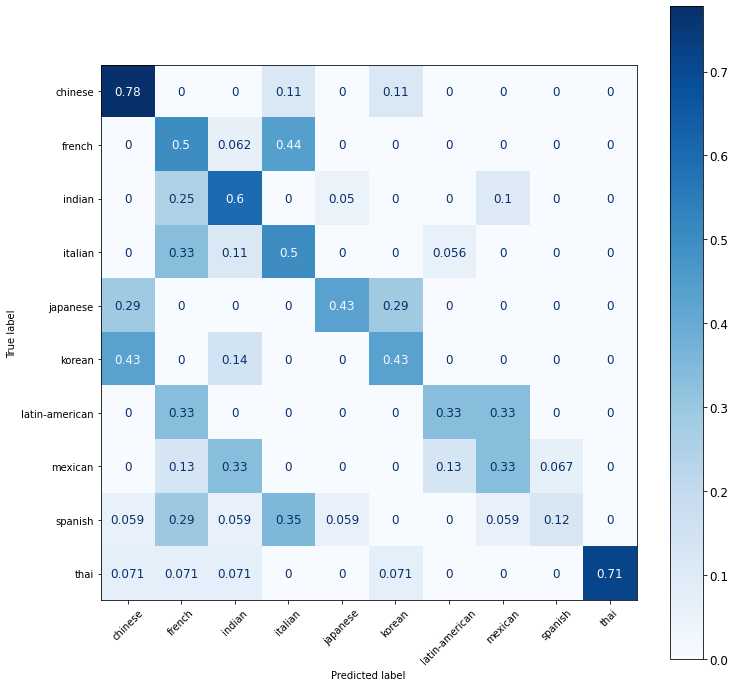

In [79]:
knn =  KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('F1 score of KNN : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of KNN : %.3f ' % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(knn, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
#plt.savefig('.../GitHub/FoodReceipeNLP/plot/knn.png')
plt.show()

### SVM

F1 score of SVC : 0.615
In-sample testing accuracy of SVC : 0.611 


C:\Users\Olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


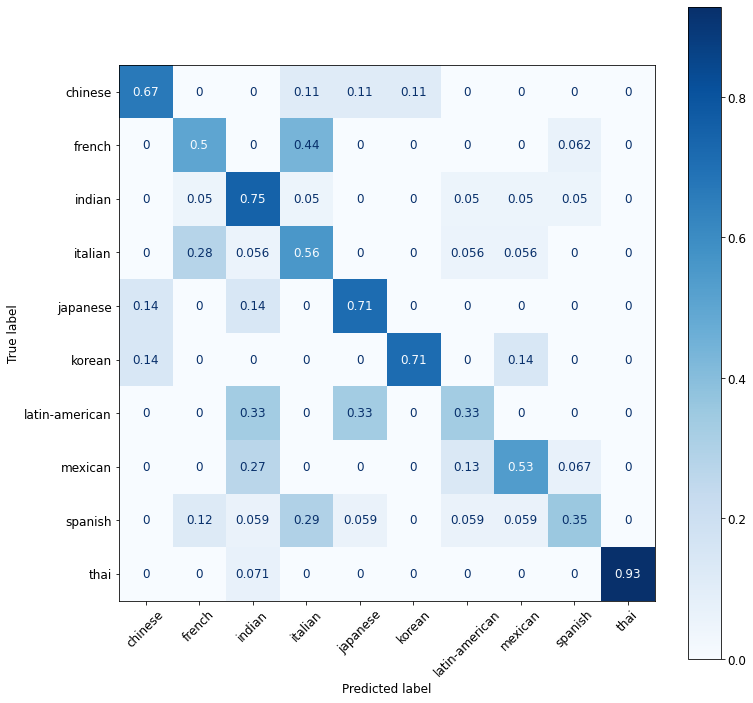

In [80]:
svc = SVC(C=1000, gamma=0.0001, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('F1 score of SVC : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of SVC : %.3f ' % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(svc, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
#plt.savefig('.../GitHub/FoodReceipeNLP/plot/svm.png')
plt.show()

In [81]:
# Hyperparameter tuning
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model using grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.120 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.370 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.430 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.410 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.430 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.450 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.180 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.420 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.480 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.470 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.270 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.300 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.300 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.400 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.370 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.230 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.200 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.230 total time=   0.0s
[CV 4/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.240 total time=   0.0s
[CV 5/5] END ...C=1, gamma=0

[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.290 total time=   0.0s
[CV 1/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.110 total time=   0.0s
[CV 2/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 3/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 4/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 5/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 1/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.250 total time=   0.0s
[CV 2/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.220 total time=   0.0s
[CV 3/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.250 total time=   0.0s
[CV 4/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.210 total time=   0.0s
[CV 5/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.240 total time=   0.0s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.170 total time=   0.0s
[CV 2/5] END ........C=100, 

[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.440 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.490 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.370 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.430 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.410 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.430 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.450 total time=   0.0s
[CV 1/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 2/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.150 total time=   0.0s
[CV 3/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.210 total time=   0.0s
[CV 4/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.160 total time=   0.0s
[CV 5/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 1/5] END ....C=1000, gam

### Random Forest

F1 score of Random Frorest : 0.532
In-sample testing accuracy of Random Forest : 0.540 


C:\Users\Olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


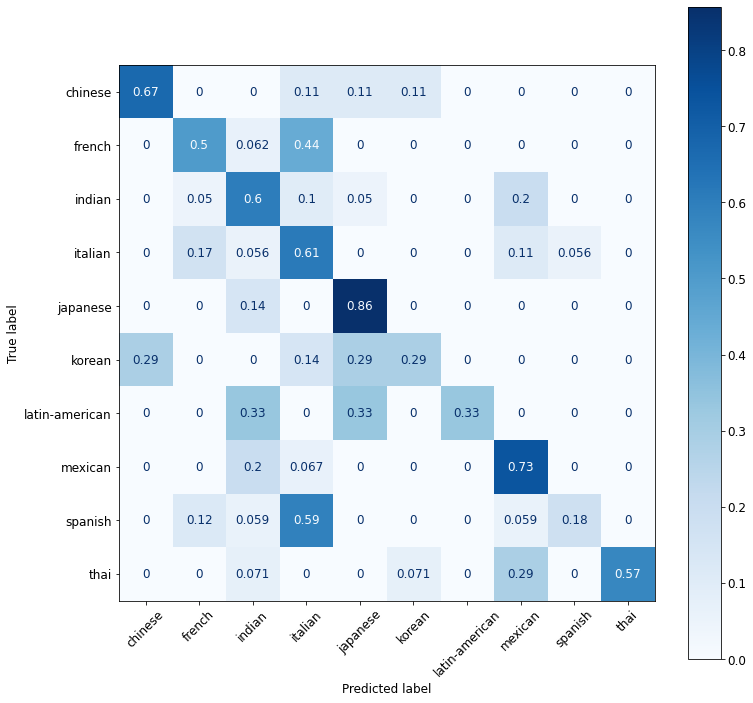

In [82]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=7, min_samples_leaf=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('F1 score of Random Frorest : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of Random Forest : %.3f ' % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
#plt.savefig('.../GitHub/FoodReceipeNLP/plot/rfc.png')
plt.show()

### CatBoost

Learning rate set to 0.5
0:	learn: 2.1243284	total: 164ms	remaining: 8.01s
1:	learn: 1.9649799	total: 326ms	remaining: 7.82s
2:	learn: 1.8733441	total: 487ms	remaining: 7.63s
3:	learn: 1.7967100	total: 652ms	remaining: 7.5s
4:	learn: 1.7080530	total: 812ms	remaining: 7.3s
5:	learn: 1.6182939	total: 976ms	remaining: 7.16s
6:	learn: 1.5708076	total: 1.14s	remaining: 6.98s
7:	learn: 1.4995310	total: 1.3s	remaining: 6.83s
8:	learn: 1.4438193	total: 1.46s	remaining: 6.63s
9:	learn: 1.3716051	total: 1.62s	remaining: 6.47s
10:	learn: 1.3086729	total: 1.81s	remaining: 6.42s
11:	learn: 1.2779882	total: 1.98s	remaining: 6.28s
12:	learn: 1.2300883	total: 2.14s	remaining: 6.09s
13:	learn: 1.1933416	total: 2.31s	remaining: 5.93s
14:	learn: 1.1555401	total: 2.47s	remaining: 5.76s
15:	learn: 1.1262294	total: 2.63s	remaining: 5.59s
16:	learn: 1.0739012	total: 2.82s	remaining: 5.47s
17:	learn: 1.0533604	total: 2.98s	remaining: 5.3s
18:	learn: 1.0334092	total: 3.16s	remaining: 5.16s
19:	learn: 0.9861580

C:\Users\Olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


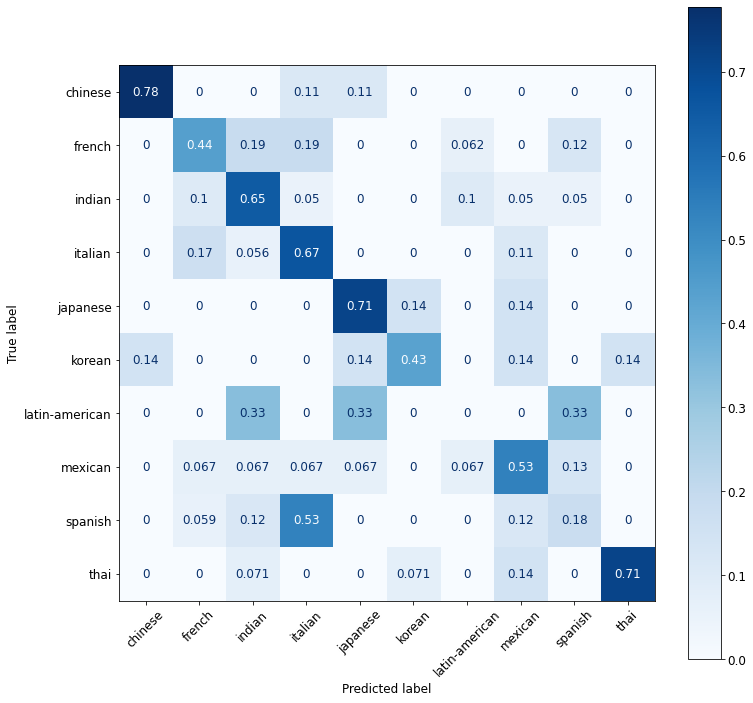

In [84]:
catboost = CatBoostClassifier(iterations=50)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
print('F1 score of CatBoost : %.3f' % f1_score(y_test, y_pred, average='weighted'))

print('In-sample testing accuracy of CatBoost : %.3f ' % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(catboost, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
#plt.savefig('.../GitHub/FoodReceipeNLP/plot/catboost.png')
plt.show()

# Cosine similarity measures

Combine the predicted labels in the test set with the original dataset that we obtained from web crawling.

In [12]:
recipe_df = pd.read_csv('C:/Users/Olive/OneDrive/Desktop/github/FoodRecipeNLP/data/all_recipes.csv')
exploration = recipe_df[["Cuisine", "Ingredients"]]

,Cuisine,Ingredients
0,mexican,"all-purpose flour,baking powder,beer,cayenne,c..."
1,mexican,"lemon juice,lime juice,tequila,triple sec"
2,mexican,"chili peppers,corn tortillas,crushed red peppe..."
3,mexican,"bay leaves,beef,black peppercorns,cider vinega..."
4,mexican,"butter,eggs,grape tomatoes,meat,mozzarella che..."
...,...,...
621,spanish,"annatto seeds,corn oil"
622,spanish,"extra virgin olive oil,fresh spinach,garlic cl..."
623,spanish,"bay leaves,chicken stock,clams,egg yolks,extra..."
624,spanish,"boneless skinless chicken thighs,chicken stock..."


In [113]:
from collections import defaultdict
count = []
for i in set(exploration["Cuisine"]):
    current = exploration[exploration["Cuisine"]==i]
    i = defaultdict(int)
    for j in current["Ingredients"]:
        inglist = j.split(",")
        for ing in inglist:
            i[ing] += 1
    for ing in i:
        i[ing] = i[ing]/len(current)
    count.append(i)    
    
commoning = []
for i in count:
    commoning.append(sorted(i.items(), key=lambda item: (-item[1]))[:10])

In [135]:
latinamerican_ing = commoning[0]
japanese_ing = commoning[1]
thai_ing = commoning[2]
indian_ing = commoning[3]
spanish_ing = commoning[4]
mexican_ing = commoning[5]
french_ing = commoning[6]
chinese_ing = commoning[7]
italian_ing = commoning[8]
korean_ing = commoning[9]

[('soy sauce', 0.6216216216216216),
 ('sesame oil', 0.5135135135135135),
 ('sugar', 0.4594594594594595),
 ('garlic cloves', 0.4594594594594595),
 ('green onions', 0.40540540540540543),
 ('water', 0.40540540540540543),
 ('garlic', 0.2972972972972973),
 ('carrots', 0.2972972972972973),
 ('salt', 0.2702702702702703),
 ('scallions', 0.24324324324324326)]

In [37]:
recipe_df = pd.read_csv('C:/Users/Olive/OneDrive/Desktop/github/FoodRecipeNLP/data/all_recipes.csv')
X_raw = recipe_df.iloc[:,:-1]
X_raw = X_raw.filter(like = "Ingredients")
y_raw = recipe_df['Cuisine']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_test_raw = X_test_raw.reset_index(drop=True)
true_label = pd.Series.to_frame(y_test_raw)
true_label = true_label.reset_index(drop=True)

test_df = pd.merge(X_test_raw, true_label, left_index=True, right_index=True)

In [39]:
# Reference: https://newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python
def word_vectorizer(lst):
    '''
    Convert a list of texts to a matrix of token counts
    '''
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(lst)
    arr = X.toarray()
    return arr

def create_heatmap(similarity, col_names, filename, cmap = plt.cm.Blues,):
    '''
    Create a heatmap to visualise cosine similarity 
    '''
    df = pd.DataFrame(similarity)
    df.columns = col_names
    df.index = col_names
    
    fig, ax = plt.subplots(figsize=(6.5,6.5))
    ax.figure.tight_layout() 
    png = sns.heatmap(df, annot = True, cmap=cmap)
    png.set_xticklabels(png.get_xticklabels(), rotation=45, horizontalalignment='right')
    #ax.figure.savefig('.../GitHub/FoodReceipeNLP/plot/' + filename + '.png', 
                      #transparent=True, bbox_inches='tight')
    return f'Heatmap produced'

### Similarity between Latin-American and Indian cuisine

Looking at the prediction result given by SVM, around 33% of Latin-American food is misclassified as Indian food, so we would like to find out the similarity between ingredients used by these two cuisines. Since there are only 3 instances under the Latin-American category, we will randomly sample 3 instances from the Indian category as comparison.

fresh cilantro leaves,fresh ground pepper,garlic cloves,green onions,jalapenos,olive oil,red wine vinegar,salt,serrano chilies,sherry wine vinegar,water  NEXT  asafetida powder,baking soda,basmati rice,coriander seeds,curry leaves,diced tomatoes,dried red chilies,eggplants,fenugreek seeds,fresh cilantro leaves,ghee,grated fresh coconut,green chili peppers,ground turmeric,mustard seeds,onions,salt,sugar,tamarind pulp,vegetable oil,white lentils,yellow lentils


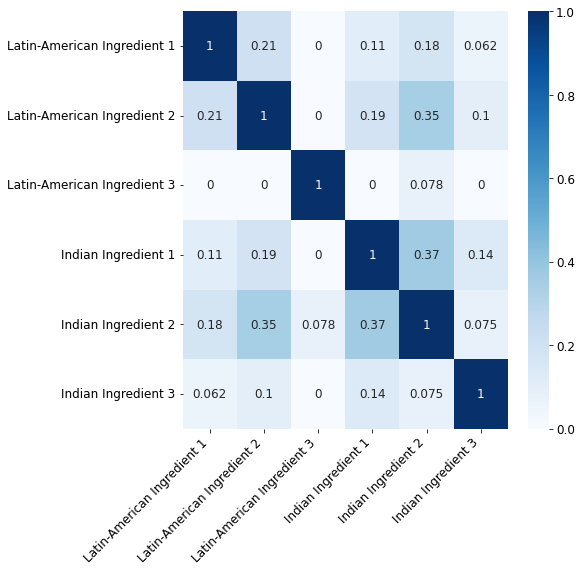

In [53]:
# Selec a subset of dataframe for comparison
latin_american = test_df[test_df['Cuisine'] == 'latin-american']
indian = test_df[test_df['Cuisine'] == 'indian'].sample(n=3, random_state=42)
latin_ingre_lst = latin_american['Ingredients'].tolist()
indian_ingre_lst = indian['Ingredients'].tolist()
lst_1 = latin_ingre_lst + indian_ingre_lst

vec_1 = word_vectorizer(lst_1)
columns = ['Latin-American Ingredient 1', 'Latin-American Ingredient 2', 'Latin-American Ingredient 3', 
           'Indian Ingredient 1', 'Indian Ingredient 2','Indian Ingredient 3',]
create_heatmap(cosine_similarity(vec_1), columns, 'latin_indian_similarity')
print(latin_ingre_lst[1], " NEXT ",indian_ingre_lst[1])

### Similarity between Chinese and Japenese cuisine

Looking at the prediction result given by SVM, 22% of the Chinese food is misclassified as Janpanese food, so we would like to find out the similarity between ingredients used by these two cuisines. We will randomly sample 3 instances from the these two categories as comparison.

chinese rice wine,dry sherry,five-spice powder,garlic,ginger,granulated sugar,hoisin sauce,honey,ketchup,pork shoulder,sesame oil,soy sauce  NEXT  canned crabmeat,cooked rice,dashi,eggs,ginger juice,light soy sauce,mirin,nori,salt,scallions


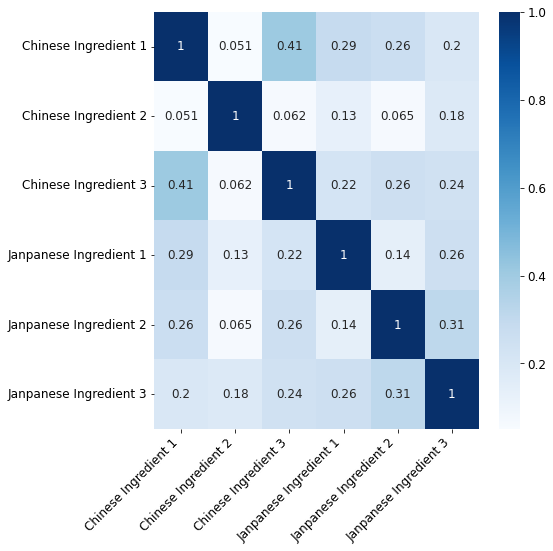

In [56]:
chinese = test_df[test_df['Cuisine'] == 'chinese'].sample(n=3, random_state=0)
japanese = test_df[test_df['Cuisine'] == 'japanese'].sample(n=3, random_state=0)
chinese_ingre_lst = chinese['Ingredients'].tolist()
japanese_ingre_lst = japanese['Ingredients'].tolist()
lst_2 = chinese_ingre_lst + japanese_ingre_lst

vec_2 = word_vectorizer(lst_2)
columns = ['Chinese Ingredient 1', 'Chinese Ingredient 2', 'Chinese Ingredient 3', 
           'Janpanese Ingredient 1', 'Janpanese Ingredient 2','Janpanese Ingredient 3',]
create_heatmap(cosine_similarity(vec_2), columns, 'chinese_japanese_similarity')
print(chinese_ingre_lst[0], " NEXT ",japanese_ingre_lst[1])